In [1]:
import numpy as np
import tensorflow as tf
from os.path import join
from glob import glob
from Model import StereoNeuralNetwork
from StereoDataGenerator import StereoDataGenerator
from Evaluation import Evaluator
import imgaug.augmenters as iaa
import numpy as np
import tensorflow as tf
from os.path import join
from glob import glob
from Model import StereoNeuralNetwork3
from StereoDataGenerator import StereoDataGenerator
from Evaluation import Evaluator
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split


from glob import glob
from Model import StereoNeuralNetwork2
# Directories
#data_root =  r'C:\Users\rocs\Documents\avci_mt\data\29_06\*.png' #r'../data/*.png'
#test_root =  r'C:\Users\rocs\Documents\avci_mt\data\29_06\TESTSET\*.png' #r'../data/*.png'

data_root =  r'C:\Users\rocs\Documents\avci_mt\data\29_06\*.png' #r'../data/*.png'

log_path = r'../logs'
checkpoints_path = r'../checkpoints'

# Train/Test-Split
filenames = list(set([filename[:-6] for filename in glob(data_root)]))
np.random.shuffle(filenames)

train_filenames, test_filenames = train_test_split(filenames, test_size=0.1)

print(len(train_filenames), len(test_filenames))
eval_filenames = train_filenames[:8]

6004 668


In [2]:
# Augmentation
seqs = []
seqs.append(iaa.Sequential([iaa.Resize(416)]).to_deterministic())
seqs.append(iaa.Sequential([iaa.Resize(416),iaa.Flipud()]).to_deterministic())
seqs.append(iaa.Sequential([iaa.Resize(416),iaa.Fliplr()]).to_deterministic())

# Evaluate
eval_gen = StereoDataGenerator(eval_filenames,shuffle=False,batch_size=8,resize_only=False,seqs=seqs,im_dim=416,output_dim=13)
left_imgs,right_imgs,labels = eval_gen.get_data(train_filenames[:8])
evaluator = Evaluator(inferred=labels,test_filenames=train_filenames[:8],im_width=416,im_height=416, fold=1)
evaluator.compareAfterAug(left_imgs,right_imgs)

In [3]:

# Augmentation
seqs = []
seqs.append(iaa.Sequential([iaa.Resize(416)]).to_deterministic())
seqs.append(iaa.Sequential([iaa.Resize(416),iaa.Flipud()]).to_deterministic())
seqs.append(iaa.Sequential([iaa.Resize(416),iaa.Fliplr()]).to_deterministic())

# Data Generator
bs = 64
train_gen = StereoDataGenerator(train_filenames,shuffle=True,batch_size=bs,resize_only=False,seqs=seqs,im_dim=416,output_dim=13)
test_gen = StereoDataGenerator(test_filenames,shuffle=False,batch_size=bs,resize_only=True,seqs=seqs,im_dim=416,output_dim=13)
#eval_gen = StereoDataGenerator(eval_filenames,shuffle=False,batch_size=bs,resize_only=False,seqs=seqs,im_dim=416,output_dim=13)

# Model
model = StereoNeuralNetwork3(im_size=416,channels=3,output_dim=13)

#TB = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=0,write_graph=True, write_images=True)
CP = tf.keras.callbacks.ModelCheckpoint(join(checkpoints_path,'weights_{epoch:02d}.hdf5'), monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=10)

model.compile(optimizer='Adam',loss=['binary_crossentropy','mse'])

# Train
epoch = 200

hist = model.fit(train_gen,epochs=epoch,callbacks=[CP],validation_data=test_gen)

# Infer
pred = model.predict(test_gen)
inferred = np.concatenate((pred[0],pred[1]), axis=3)


# Evaluate
#left_imgs,right_imgs,labels = eval_gen.get_data(eval_filenames)
#evaluator = Evaluator(inferred=labels,test_filenames=eval_filenames,im_width=416,im_height=416)
#evaluator.compareAfterAug(left_imgs,right_imgs)
evaluator = Evaluator(inferred=inferred
                      ,test_filenames=test_filenames,im_width=1280,im_height=720, fold =0 )
evaluator.run()

print('done')

Epoch 1/200
93/93 [==============================] - 527s 6s/step - loss: 0.2372 - detection_loss: 0.1401 - params_loss: 0.0971 - val_loss: 0.2045 - val_detection_loss: 0.1284 - val_params_loss: 0.0761
Epoch 2/200
93/93 [==============================] - 506s 5s/step - loss: 0.1551 - detection_loss: 0.0786 - params_loss: 0.0765 - val_loss: 0.1593 - val_detection_loss: 0.0922 - val_params_loss: 0.0671
Epoch 3/200
93/93 [==============================] - 491s 5s/step - loss: 0.1295 - detection_loss: 0.0617 - params_loss: 0.0678 - val_loss: 0.1318 - val_detection_loss: 0.0689 - val_params_loss: 0.0629
Epoch 4/200
93/93 [==============================] - 496s 5s/step - loss: 0.1179 - detection_loss: 0.0550 - params_loss: 0.0629 - val_loss: 0.1955 - val_detection_loss: 0.1268 - val_params_loss: 0.0688
Epoch 5/200
93/93 [==============================] - 482s 5s/step - loss: 0.1091 - detection_loss: 0.0495 - params_loss: 0.0596 - val_loss: 0.1049 - val_detection_loss: 0.0486 - val_params_los

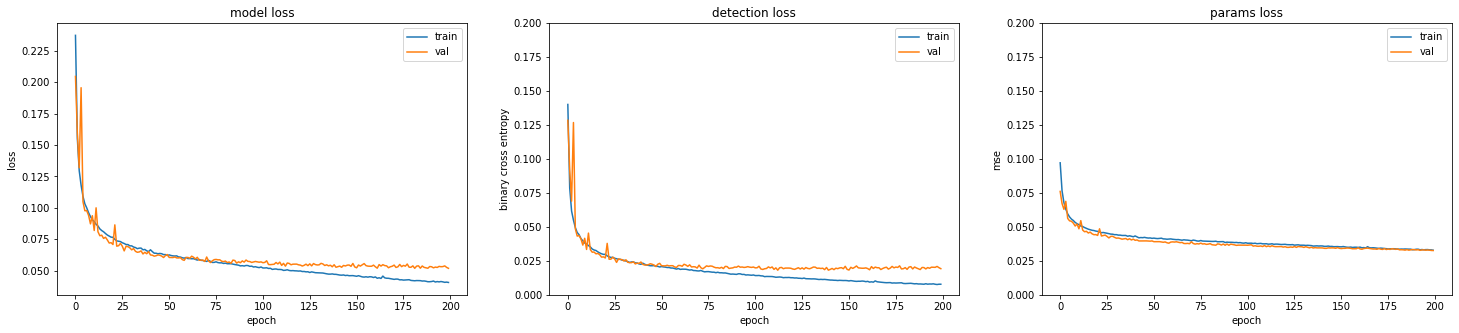

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,5))

# plot loss curve
plt.subplot(1,3,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
#plt.ylim((0,0.2))

plt.subplot(1,3,2)
plt.plot(hist.history['detection_loss'])
plt.plot(hist.history['val_detection_loss'])
plt.title('detection loss')
plt.ylabel('binary cross entropy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.ylim((0,0.2))

plt.subplot(1,3,3)
plt.plot(hist.history['params_loss'])
plt.plot(hist.history['val_params_loss'])
plt.title('params loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.ylim((0,0.2))

plt.show()

